In [ ]:
import pandas as pd

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Sensationalism and Opinionism (Fake News) detection/Training.csv")

In [ ]:
X[1000], y[1000]

('GENEVA (Reuters) - President Bashar al-Assad and his family have no role in the future of Syria, U.S. Secretary of State Rex Tillerson said on Thursday ahead of peace talks aiming at a political transition scheduled to resume next month. Tillerson said that the Trump administration backed the Geneva peace talks as the only way to end the more than six-year-old war and move to a political transition and elections. He was speaking after holding talks with U.N. Special Envoy for Syria Staffan de Mistura, who announced that stalled peace talks between the Syrian government and still-to-be-united opposition would resume in Geneva on Nov. 28. “The United States wants a whole and unified Syria with no role for Bashar al-Assad in the government,” Tillerson told reporters in the Swiss city at the end of a week-long trip that took him to Saudi Arabia, Qatar, Pakistan and India. “It is our view and I have said this many times as well that we do not believe that there is a future for the Assad r

In [ ]:
data['label'].value_counts()

,count
label,
Real,42608
Fake,40931


In [ ]:
def change_labels(val):
  if val == "Real":
     return "Low"
  else:
    return "High"

In [ ]:
data['new_label'] = data['label'].apply(change_labels)

In [ ]:
X = data['Text']
y = data['new_label']

In [ ]:
base_path = "/content/drive/MyDrive/Sensationalism and Opinionism (Fake News) detection/"

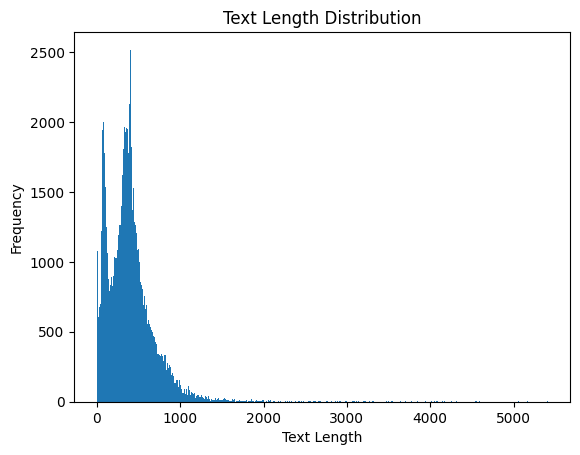

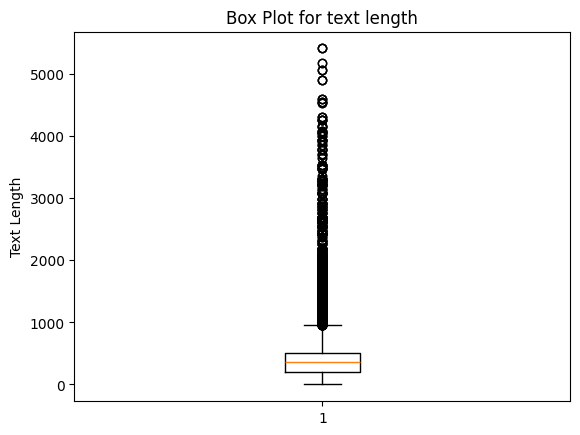

In [ ]:
import matplotlib.pyplot as plt
import os

os.makedirs(os.path.join(base_path, "images"), exist_ok=True)
fig_path = os.path.join(base_path, "images")


lengths = [len(text.split()) for text in X]
plt.hist(lengths, bins=500)
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.title("Text Length Distribution")
plt.savefig(f"{fig_path}/TextLength_Frequency_Distribution")
plt.show()


import matplotlib.pyplot as plt
lengths = [len(text.split()) for text in X]
plt.boxplot(lengths)
plt.ylabel("Text Length")
plt.title("Box Plot for text length")
plt.savefig(f"{fig_path}/BoxPlot_for_text_length")
plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data['new_label'])

In [ ]:
label_encoder.classes_

array(['High', 'Low'], dtype=object)

In [ ]:
def load_glove_embeddings(glove_path, word_index, embedding_dim=100):
    """
      GloVe Embeddings maker: It takes the word index and uses glove 6B 100 dimensions corpus to generate embeddings!

      Args:
        glove_path (string): path to the glove file
        word_index (dictionary): word indexes generated after tokenization
        embedding_dimensions (int): in this case 100 as we use 100 dimensions corpus

      Returns
        (array(array(float))): Generated Embeddings
    """
    embeddings_index = {}

    with open(glove_path, encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]  # Word
            vector = np.asarray(values[1:], dtype="float32")  # Embedding vector
            embeddings_index[word] = vector

    # Create embedding matrix
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector  # Words found in GloVe

    return embedding_matrix

In [ ]:
# HELPER FUNCTIONS
import re
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.stem import PorterStemmer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from nltk.corpus import stopwords
import string

nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
exclude = string.punctuation
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
  new_text = []
  for word in text.split():
    if word not in stop_words:
      new_text.append(word)
  return " ".join(new_text)

def remove_punc(text):
    return text.translate(str.maketrans('', '', exclude))

def remove_urls(text):
    text = re.sub(r'http\S+|www.\S+', '', text)
    return text

def remove_numbers(text):
    return re.sub(r'\d+', '', text)

def clean_text(X, max_sequence_length=100):
  """
    Text cleaner: It does stemming, tokenization and embedding generation of the data
    Args:
      X (array(str)): Articles
      y (array(int)): Categories of articles
      max_sequence_length (int): Max length of sequence

    Returns:
      X_resampled, y_resampled, embedding_matrix, tokenizer
  """

  lower_text_X = [text.lower() for text in X]
  lower_text_X = [remove_urls(text) for text in lower_text_X]
  lower_text_X = [remove_numbers(text) for text in lower_text_X]

  no_punc_text_X = [remove_punc(text) for text in lower_text_X]

  stop_word_clean_text_X = [remove_stopwords(word) for word in no_punc_text_X]

  stemmer = PorterStemmer()
  stemmed_text = [" ".join([stemmer.stem(word) for word in sentence.split()]) for sentence in stop_word_clean_text_X]

  # lemmatizer = WordNetLemmatizer()
  # stemmed_text = [" ".join([lemmatizer.lemmatize(word) for word in sentence.split()]) for sentence in stemmed_text]

  tokenizer = Tokenizer(
      filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\tâ€\n',
      oov_token="<OOV>",
      lower=True,
      num_words=30000)
  tokenizer.fit_on_texts(stemmed_text)

  sequences = tokenizer.texts_to_sequences(stemmed_text)
  padded_sequences = pad_sequences(sequences, padding= "post",maxlen=max_sequence_length)

  word_index = tokenizer.word_index
  glove_path = "/content/drive/MyDrive/Major Project/glove.6B.100d.txt"
  embedding_matrix = load_glove_embeddings(glove_path=glove_path, word_index=word_index)

  return padded_sequences, embedding_matrix, tokenizer


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
X_padded, embedding_matrix, tokenizer= clean_text(X, max_sequence_length=350)

In [ ]:
try:
    with open(f"{base_path}/tests/current_model_count.txt", "r") as file:
        test_count = int(file.read())
except FileNotFoundError:
        test_count = 0
test_count += 1

In [ ]:
import pickle

os.makedirs(f"{base_path}/tests/test_{test_count}", exist_ok=True)

# Save padded sequences
np.save(f"{base_path}/tests/test_{test_count}/X_padded.npy", X_padded)

# Save embedding matrix
np.save(f"{base_path}/tests/test_{test_count}/embedding_matrix.npy", embedding_matrix)

# Save tokenizer
with open(f"{base_path}/tests/test_{test_count}/tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

In [ ]:
MAX_FEATURES = 196506
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Embedding, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential

def model_maker_LSTM(embedding_matrix, max_features=MAX_FEATURES, op_layer=3, embedding_dim=100):
  model = Sequential()

  model.add(Embedding(input_dim=max_features,
                      output_dim=embedding_dim,
                      weights=[embedding_matrix],
                      trainable=True))

  # LSTM Layer
  model.add(Bidirectional(LSTM(128, activation="tanh", return_sequences=True)))
  model.add(Dropout(0.2))  # Prevent overfitting
  model.add(Bidirectional(LSTM(64, activation="tanh")))
  # Batch Normalization
  model.add(BatchNormalization())
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.3))
  # Output Layer (Softmax for multi-class classification)
  model.add(Dense(op_layer, activation="softmax"))

  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  return model

In [ ]:
def create_models(embedding_matrix):
  models = {}
  models["model_lstm"] = model_maker_LSTM(embedding_matrix=embedding_matrix, op_layer=2)
  return models

In [ ]:
model = create_models(embedding_matrix=embedding_matrix)

In [ ]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

def create_split_and_resampling(X, y):
  print("Creating Split...")
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
  X_train = np.array(X_train)
  y_train = np.array(y_train)
  # unique, counts = np.unique(y_res, return_counts=True)
  y_train = to_categorical(y_train, num_classes=2)
  # print(f"Values resampled by {counts}")
  print("Split Created!")
  return X_train, y_train, X_test, y_test


In [ ]:
X_train, y_train, X_test, y_test = create_split_and_resampling(X=X_padded, y=y)

Creating Split...
Split Created!


In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((66831, 350), (66831, 2), (16708, 350), (16708,))

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

def model_training(models, early_stopping, train_model="all", class_weights_dict=None):

  history = {}
  for model_name, model in models.items():
    if model_name in train_model or train_model == "all":
      print("="*50)
      print(f"Training {model_name}...")
      history[model_name] = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=16,
        validation_split=0.2,
        # class_weight = class_weights_dict,
        callbacks=[early_stopping],
      )
      print(f"{model_name} trained successfully!")
  print("MODEL(s) TRAINED SUCCESSFULLY")

  return history

In [ ]:
history = model_training(model, early_stopping)

Training model_lstm...
Epoch 1/50
3342/3342 ━━━━━━━━━━━━━━━━━━━━ 252s 72ms/step - accuracy: 0.9535 - loss: 0.1203 - val_accuracy: 0.9965 - val_loss: 0.0135
Epoch 2/50
3342/3342 ━━━━━━━━━━━━━━━━━━━━ 245s 73ms/step - accuracy: 0.9959 - loss: 0.0175 - val_accuracy: 0.9978 - val_loss: 0.0083
Epoch 3/50
3342/3342 ━━━━━━━━━━━━━━━━━━━━ 257s 77ms/step - accuracy: 0.9984 - loss: 0.0078 - val_accuracy: 0.9985 - val_loss: 0.0084
Epoch 4/50
3342/3342 ━━━━━━━━━━━━━━━━━━━━ 241s 71ms/step - accuracy: 0.9947 - loss: 0.0240 - val_accuracy: 0.9981 - val_loss: 0.0113
Epoch 5/50
3342/3342 ━━━━━━━━━━━━━━━━━━━━ 248s 67ms/step - accuracy: 0.9976 - loss: 0.0105 - val_accuracy: 0.9981 - val_loss: 0.0117
Epoch 6/50
3342/3342 ━━━━━━━━━━━━━━━━━━━━ 218s 65ms/step - accuracy: 0.9993 - loss: 0.0030 - val_accuracy: 0.9992 - val_loss: 0.0058
Epoch 7/50
3342/3342 ━━━━━━━━━━━━━━━━━━━━ 267s 67ms/step - accuracy: 0.9995 - loss: 0.0031 - val_accuracy: 0.9984 - val_loss: 0.0065
Epoch 8/50
3342/3342 ━━━━━━━━━━━━━━━━━━━━ 261s

In [ ]:
# SCRIPT FOR SAVING IMPORTANT MODEL
def save_models(models):
    os.makedirs(f"{base_path}/tests/test_{test_count}/models", exist_ok=True)
    for model_name, model in models.items():
        model.save(f"{base_path}/tests/test_{test_count}/models/model_{model_name}.keras")

with open(f"{base_path}/current_model_count.txt", "w") as file:
    file.write(str(test_count))


In [ ]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(predictions, y_test, save_fig=True):
    cm_dir = os.path.join(base_path, f"tests/test_{test_count}", "confusion_matrices")
    os.makedirs(cm_dir, exist_ok=True)

    for model, prediction in predictions.items():
        y_pred_labels = np.argmax(prediction, axis=1)
        cm = confusion_matrix(y_test, y_pred_labels)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=['high', 'low'],
                    yticklabels=['high', 'low'])
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(f"{model} Confusion Matrix")
        plt.tight_layout()
        if save_fig:
          plt.savefig(os.path.join(cm_dir, f"{model}_cm.png"))
        plt.show()
        plt.close()

def print_metrics(predictions, y_test):
    metrics_path = os.path.join(base_path, f"tests/test_{test_count}", "metrics.txt")
    os.makedirs(os.path.dirname(metrics_path), exist_ok=True)

    with open(metrics_path, "w") as f:
        for model, prediction in predictions.items():
            y_pred_labels = np.argmax(prediction, axis=1)
            report = classification_report(y_test, y_pred_labels, target_names=["High", "low"])
            print(f"Metrics: {model}")
            print("=" * 25)
            print(report)
            f.write(f"Metrics: {model}\n")
            f.write("=" * 25 + "\n")
            f.write(report + "\n\n")

In [ ]:
save_models(model)

In [ ]:
predictions = {}
predictions['model_lstm'] = model['model_lstm'].predict(X_test)

523/523 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step


In [ ]:
predictions['model_lstm']

array([[1.0000000e+00, 7.8432694e-12],
       [1.5173135e-10, 1.0000000e+00],
       [1.0000000e+00, 4.3162834e-15],
       ...,
       [1.0000000e+00, 1.2125849e-12],
       [9.3633986e-08, 9.9999988e-01],
       [1.0000000e+00, 1.8137692e-12]], dtype=float32)

Metrics: model_lstm
              precision    recall  f1-score   support

        High       1.00      1.00      1.00      8186
         low       1.00      1.00      1.00      8522

    accuracy                           1.00     16708
   macro avg       1.00      1.00      1.00     16708
weighted avg       1.00      1.00      1.00     16708



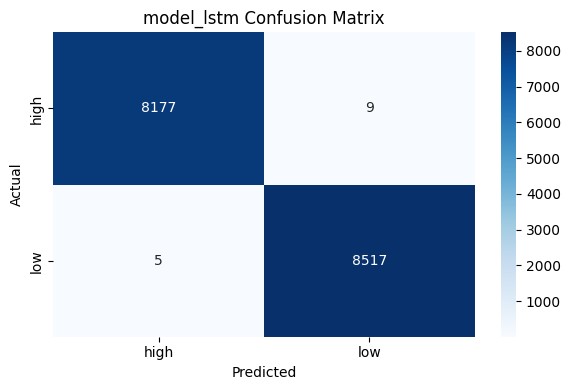

In [ ]:
print_metrics(y_test=y_test, predictions=predictions)
print_confusion_matrix(y_test=y_test, predictions=predictions)

In [ ]:
INFO_PATH = os.path.join(base_path, f"tests/test_{test_count}", "info.txt")
with open(f"{INFO_PATH}", "w+") as f:
  f.write(f"TEST NUMBER: {test_count}\n")
  f.write("BATCH SIZE = 16\n")
  f.write("WORDS = 350\n")
  f.write("30,000 VOCABULARY\n")
  f.write("MODEL: LSTM\n")
  f.write("NLP: TEXT CLEANING(stopwords, punc removal), stemming, tokenization(with filtration), padded sequence(POST)\n")
  f.write("EMBEDDING: GLOVE\n")


In [ ]:
import os
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

def plot_roc_curve(y_true, y_pred_prob, n_classes=2, title="ROC Curve - Soft Voting Ensemble", save_fig=True):

    # Class labels for your specific case
    classes = {
        0: "High",
        1: "Low",
    }

    # Step 1: Binarize the labels
    y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

    if n_classes == 2:
        y_true_bin = np.hstack((1 - y_true_bin, y_true_bin))  # make it (n_samples, 2)

    # Step 2: Compute ROC and AUC for each class
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute macro-average ROC
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)

    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Step 3: Plot
    plt.figure(figsize=(8, 6))
    colors = ['green', 'red']
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color,
                 label=f'{classes[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot(fpr["macro"], tpr["macro"], color='black', linestyle='--', label=f"Macro Avg (AUC = {roc_auc['macro']:.2f})")

    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.grid()
    plt.tight_layout()


    if save_fig:
        metric_dir = os.path.join(base_path, f"tests/test_{test_count}/metric_curves")
        os.makedirs(metric_dir, exist_ok=True)

        plt.savefig(os.path.join(metric_dir, f"{title}_roc_curve.png"))
        print(f"ROC curve saved to {metric_dir}/roc_curve.png")

    plt.show()

ROC curve saved to /content/drive/MyDrive/Sensationalism and Opinionism (Fake News) detection/tests/test_1/metric_curves/roc_curve.png


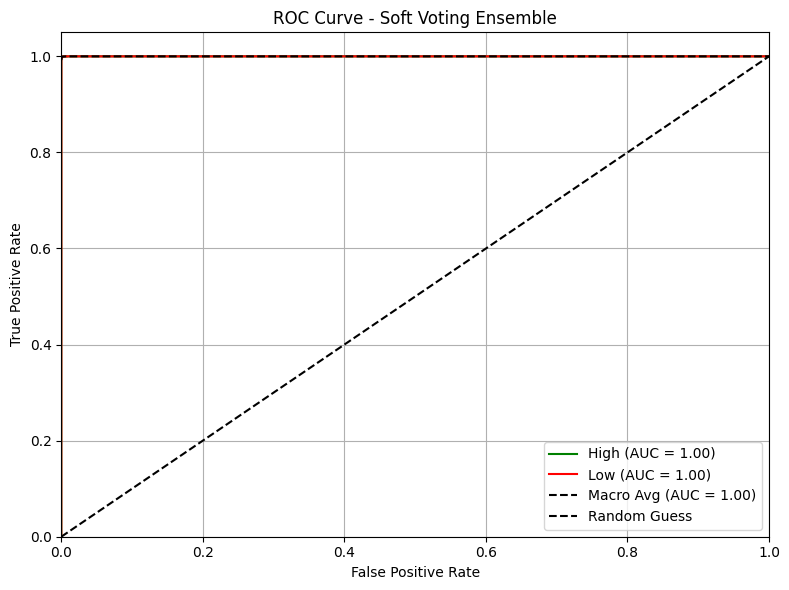

In [ ]:
plot_roc_curve(y_pred_prob=predictions['model_lstm'], y_true=y_test)

In [ ]:
predictions['model_lstm'].shape

(16708, 2)

In [ ]:
from sklearn.preprocessing import label_binarize

y_test.shape, predictions['model_lstm'].shape

((16708,), (16708, 2))

In [ ]:
y_test, predictions['model_lstm']

(array([0, 1, 0, ..., 0, 1, 0]),
 array([[1.0000000e+00, 7.8432694e-12],
        [1.5173135e-10, 1.0000000e+00],
        [1.0000000e+00, 4.3162834e-15],
        ...,
        [1.0000000e+00, 1.2125849e-12],
        [9.3633986e-08, 9.9999988e-01],
        [1.0000000e+00, 1.8137692e-12]], dtype=float32))

In [ ]:
text = "The Delhi Cabinet Tuesday approved a draft Bill to regulate fees in private schools, weeks after several parents protested outside the Directorate of Education (DoE) office, demanding the rollback of hiked school fees for their wards. Following the continuous protests by parents, DoE said earlier this month it has initiated a probe against the private unaided schools which are illegally hiking fees, and the action would include de-recognition and possible takeover of school managements. Addressing a press conference, CM Gupta said, 'We have passed a draft Bill in the Cabinet meeting, applicable to all 1,677 aided and unaided private schools, to fix guidelines and procedures for fee hikes…” The Delhi chief minister said there were complaints, and the parents were in panic due to the fee hikes. 'Several parents also complained that the school administrations were pressuring their children in school over the fees. We sent out DMs to conduct a detailed study, understand how the fees were hiked in schools, and what the procedures were to regulate fees. We found that no previous government took any steps to regulate fee hikes in schools.'Gupta said that after undertaking detailed studies, the government took action. “Since 1973, there has been no provision to address this fee hike issue. But, today I am happy to say that the Delhi government has taken a historic and brave decision to regulate fees in private and government schools,' she said."

In [ ]:
def pred_pipeline(text, model):
    lower_text_X = text.lower()
    lower_text_X = remove_urls(text)
    lower_text_X = remove_numbers(text)

    no_punc_text_X = remove_punc(text)
    stop_word_clean_text_X = [remove_stopwords(word) for word in no_punc_text_X]

    stemmer = PorterStemmer()
    stemmed_text = [" ".join([stemmer.stem(word) for word in text.split()])]

    # lemmatizer = WordNetLemmatizer()
    # stemmed_text = [" ".join([lemmatizer.lemmatize(word) for word in sentence.split()]) for sentence in stemmed_text]

    with open(f"{base_path}/tests/test_{test_count}/tokenizer.pkl", "wb") as f:
        tokenizer = pickle.load(tokenizer, f)

    sequences = tokenizer.texts_to_sequences(stemmed_text)
    padded_sequences = pad_sequences(sequences, padding= "post",maxlen=350)

    return np.argmax(model.predict(padded_sequences))

In [ ]:
pred_pipeline(text, model['model_lstm'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


np.int64(0)